# IMPORTING DATA

In [ ]:
import pandas as pd
import re
from datetime import datetime
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [ ]:
!gdown 1XXeBJYmh3R6V27yv-td0SzEHoiAr3Isb

Downloading...
From: https://drive.google.com/uc?id=1XXeBJYmh3R6V27yv-td0SzEHoiAr3Isb
To: /content/Customer Dataset 1.csv
100% 45.4M/45.4M [00:00<00:00, 48.2MB/s]


In [ ]:
df = pd.read_csv("Customer Dataset 1.csv", delimiter=";", encoding="ISO-8859-1")
df.head()

,No_Invoice,Kode_Barang,Deskripsi_Barang,Jumlah,Tgl_Invoice,Harga_Satuan,ID_Customer,Negara
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/10 08.26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/10 08.26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/10 08.26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/10 08.26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/10 08.26,3.39,17850.0,United Kingdom


# DATA CLEANING & EDA

In [ ]:
df

,No_Invoice,Kode_Barang,Deskripsi_Barang,Jumlah,Tgl_Invoice,Harga_Satuan,ID_Customer,Negara
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/01/10 08.26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/01/10 08.26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/01/10 08.26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/01/10 08.26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/01/10 08.26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/09/11 12.50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/09/11 12.50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/09/11 12.50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/09/11 12.50,4.15,12680.0,France


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   No_Invoice        541909 non-null  object 
 1   Kode_Barang       541909 non-null  object 
 2   Deskripsi_Barang  540455 non-null  object 
 3   Jumlah            541909 non-null  int64  
 4   Tgl_Invoice       541909 non-null  object 
 5   Harga_Satuan      541909 non-null  float64
 6   ID_Customer       406829 non-null  float64
 7   Negara            541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df.isnull().sum()

,0
No_Invoice,0
Kode_Barang,0
Deskripsi_Barang,1454
Jumlah,0
Tgl_Invoice,0
Harga_Satuan,0
ID_Customer,135080
Negara,0


In [ ]:
df.duplicated().sum()

np.int64(5268)

In [ ]:
df = df[~df.duplicated()]
df.shape

(536641, 8)

In [ ]:
clean_df = df.copy()

# 1. Split No_Invoice menjadi Type_Invoice dan membuang invoice yang tidak regular
clean_df["Type_Invoice"] = clean_df["No_Invoice"].astype(str).str.extract(r"([A-Z]+)")
clean_df["No_Invoice"] = clean_df["No_Invoice"].astype(str).str.replace(r"[A-Z]+", "", regex=True)
clean_df = clean_df[clean_df["Type_Invoice"].isna()]
clean_df = clean_df.drop(columns=["Type_Invoice"])

# 2. Extract all alphabetic characters from Kode_Barang
clean_df["Kode_Barang"] = clean_df["Kode_Barang"].astype(str).str.replace(r"[A-Z]+", "", regex=True)
clean_df["Kode_Barang"] = pd.to_numeric(clean_df["Kode_Barang"], errors="coerce")
clean_df["Kode_Barang"] = clean_df["Kode_Barang"].fillna(0)

# 3. Menghapus Data dengan kuantitas dibawah 0 dan menjumlahkan Harga Barang (Jumlah * Harga_Satuan)
clean_df = clean_df[clean_df['Jumlah']>=0]
clean_df = clean_df.copy()  # Ensure it's not a view
clean_df["Harga_Jumlah"] = clean_df["Jumlah"] * clean_df["Harga_Satuan"]

# 4. Menghapus Jam pada tanggal invoice
clean_df["Tgl_Invoice"] = clean_df["Tgl_Invoice"].astype(str).str.replace(r"\d{1,2}\.\d{1,2}", "", regex=True)
clean_df["Tgl_Invoice"] = clean_df["Tgl_Invoice"].astype(str).str.replace(r"\d{1,2}\:\d{1,2}", "", regex=True)
clean_df["Tgl_Invoice"] = pd.to_datetime(clean_df["Tgl_Invoice"], errors='coerce', dayfirst=False)
clean_df["Tgl_Invoice"] = clean_df["Tgl_Invoice"].dt.strftime("%m-%d-%Y")

# 5. Perbaiki Type Data]
clean_df["No_Invoice"] = clean_df["No_Invoice"].astype(int)
clean_df["Kode_Barang"] = clean_df["Kode_Barang"].astype(int)

# 6. Sort Column
clean_df = clean_df[["No_Invoice", "Kode_Barang",
         "Deskripsi_Barang", "Jumlah", "Tgl_Invoice", "Harga_Satuan", "Harga_Jumlah", "ID_Customer", "Negara"]]

# 7. Jumlah Harga dalam satu invoice (Sum(Jumlah_Harga) dalam satu invoice)
total_transaksi = clean_df.groupby("No_Invoice", as_index=False).agg({
    "Harga_Jumlah": "sum",
    "Tgl_Invoice": "first",
    "ID_Customer": "first",
    "Negara": "first"
})

<ipython-input-9-2ce799fa3f7a>:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  clean_df["Tgl_Invoice"] = pd.to_datetime(clean_df["Tgl_Invoice"], errors='coerce', dayfirst=False)


In [ ]:
clean_df.head()

,No_Invoice,Kode_Barang,Deskripsi_Barang,Jumlah,Tgl_Invoice,Harga_Satuan,Harga_Jumlah,ID_Customer,Negara
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010,2.55,15.30,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010,3.39,20.34,17850.0,United Kingdom
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010,2.75,22.00,17850.0,United Kingdom
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010,3.39,20.34,17850.0,United Kingdom
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010,3.39,20.34,17850.0,United Kingdom


In [ ]:
df["Negara"].value_counts(normalize=True)

,proportion
Negara,
United Kingdom,0.913646
Germany,0.017665
France,0.015916
EIRE,0.015250
Spain,0.004711
Netherlands,0.004418
Belgium,0.003855
Switzerland,0.003716
Portugal,0.002814


In [ ]:
# Menjadikan UK sebagai satu negara dan menyatukan lainnya menjadi "Others"
clean_country = clean_df['Negara'].apply(lambda x:'United Kingdom' if x=='United Kingdom' else 'Others')
country_counts = clean_country.value_counts(normalize=True)
country_counts

,proportion
Negara,
United Kingdom,0.914626
Others,0.085374


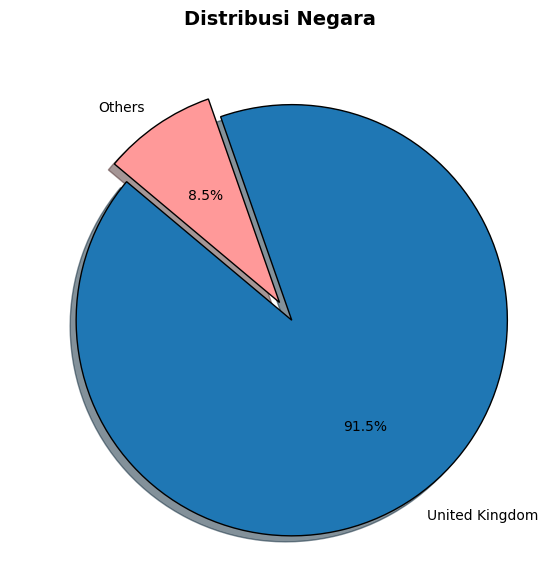

In [ ]:
colors = ['#1f77b4', '#ff9999']

# Membuat pie chart dengan eksplode untuk United Kingdom
explode = (0.1, 0)  # Memisahkan sedikit bagian pertama (United Kingdom)

plt.figure(figsize=(7, 7))
plt.pie(
    country_counts,
    labels=country_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    shadow=True,
    startangle=140,
    wedgeprops={'edgecolor': 'black'}
)

# Menambahkan judul dengan font yang lebih besar dan tebal
plt.title("Distribusi Negara", fontsize=14, fontweight='bold')

# Menampilkan plot
plt.show()

In [ ]:
clean_df

,No_Invoice,Kode_Barang,Deskripsi_Barang,Jumlah,Tgl_Invoice,Harga_Satuan,Harga_Jumlah,ID_Customer,Negara
0,536365,85123,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010,2.55,15.30,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010,3.39,20.34,17850.0,United Kingdom
2,536365,84406,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010,2.75,22.00,17850.0,United Kingdom
3,536365,84029,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010,3.39,20.34,17850.0,United Kingdom
4,536365,84029,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010,3.39,20.34,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12-09-2011,0.85,10.20,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12-09-2011,2.10,12.60,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12-09-2011,4.15,16.60,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12-09-2011,4.15,16.60,12680.0,France


In [ ]:
total_transaksi

,No_Invoice,Harga_Jumlah,Tgl_Invoice,ID_Customer,Negara
0,536365,139.12,12-01-2010,17850.0,United Kingdom
1,536366,22.20,12-01-2010,17850.0,United Kingdom
2,536367,278.73,12-01-2010,13047.0,United Kingdom
3,536368,70.05,12-01-2010,13047.0,United Kingdom
4,536369,17.85,12-01-2010,13047.0,United Kingdom
...,...,...,...,...,...
20720,581583,124.60,12-09-2011,13777.0,United Kingdom
20721,581584,140.64,12-09-2011,13777.0,United Kingdom
20722,581585,329.05,12-09-2011,15804.0,United Kingdom
20723,581586,339.20,12-09-2011,13113.0,United Kingdom


In [ ]:
clean_df[clean_df["Deskripsi_Barang"].str.islower() |
         clean_df["Deskripsi_Barang"].str.istitle() |
         clean_df["Deskripsi_Barang"].isna()]["Deskripsi_Barang"].value_counts(dropna=False)

,count
Deskripsi_Barang,
NaN,592
Manual,323
Next Day Carriage,79
check,39
found,25
adjustment,14
Bank Charges,12
Dotcomgiftshop Gift Voucher £20.00,9
Dotcomgiftshop Gift Voucher £10.00,8


In [ ]:
# Menghapus Data yang bukan pesanan
clean_df = clean_df[~(clean_df["Deskripsi_Barang"].str.islower() |
                      clean_df["Deskripsi_Barang"].str.istitle() |
                      clean_df["Deskripsi_Barang"].isna())]

clean_df.shape

(524862, 9)

In [ ]:
# Menghapus Data yang memiliki ID_Customer = NULL
clean_df = clean_df.dropna(subset=["ID_Customer"])
clean_df["ID_Customer"] = clean_df["ID_Customer"].astype(int)

clean_df.shape

(392353, 9)

In [ ]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392353 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   No_Invoice        392353 non-null  int64  
 1   Kode_Barang       392353 non-null  int64  
 2   Deskripsi_Barang  392353 non-null  object 
 3   Jumlah            392353 non-null  int64  
 4   Tgl_Invoice       392353 non-null  object 
 5   Harga_Satuan      392353 non-null  float64
 6   Harga_Jumlah      392353 non-null  float64
 7   ID_Customer       392353 non-null  int64  
 8   Negara            392353 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 29.9+ MB


In [ ]:
clean_df.isnull().sum()

,0
No_Invoice,0
Kode_Barang,0
Deskripsi_Barang,0
Jumlah,0
Tgl_Invoice,0
Harga_Satuan,0
Harga_Jumlah,0
ID_Customer,0
Negara,0


# MODELLING CUSTOMER SEGMENTATION

In [ ]:
model_df = clean_df.copy()
# Hilangkan spasi ekstra dan ubah string kosong menjadi NaN
model_df['Tgl_Invoice'] = model_df['Tgl_Invoice'].str.strip()
model_df["Tgl_Invoice"] = model_df['Tgl_Invoice'].replace("", np.nan)

# Cek apakah ada NaN setelah pembersihan
print(model_df['Tgl_Invoice'].isna().sum())

# Konversi ke datetime dengan format yang fleksibel
model_df['Tgl_Invoice'] = pd.to_datetime(model_df['Tgl_Invoice'], format="%m-%d-%Y")

snapshot_date = model_df['Tgl_Invoice'].max() + pd.Timedelta(days=1)  # Asumsi data hingga hari terakhir

0


In [ ]:
rfm = model_df.groupby('ID_Customer').agg({
    'Negara': lambda x: x.value_counts().index[0],  # Negara
    'Tgl_Invoice': lambda x: (snapshot_date - x.max()).days,  # Recency
    'No_Invoice': 'count',  # Frequency
    'Harga_Jumlah': 'sum'   # Monetary
}).reset_index()
# Ubah nama kolom
rfm.columns = ['ID_Customer', 'Negara', 'Recency', 'Frequency', 'Monetary']
rfm

,ID_Customer,Negara,Recency,Frequency,Monetary
0,12346,United Kingdom,326,1,77183.60
1,12347,Iceland,3,182,4310.00
2,12348,Finland,76,31,1797.24
3,12349,Italy,19,73,1757.55
4,12350,Norway,311,17,334.40
...,...,...,...,...,...
4330,18280,United Kingdom,278,10,180.60
4331,18281,United Kingdom,181,7,80.82
4332,18282,United Kingdom,8,12,178.05
4333,18283,United Kingdom,4,719,2039.58


In [ ]:
rfm[rfm[['Recency', 'Frequency', 'Monetary']].isna().any(axis=1)]

,ID_Customer,Negara,Recency,Frequency,Monetary


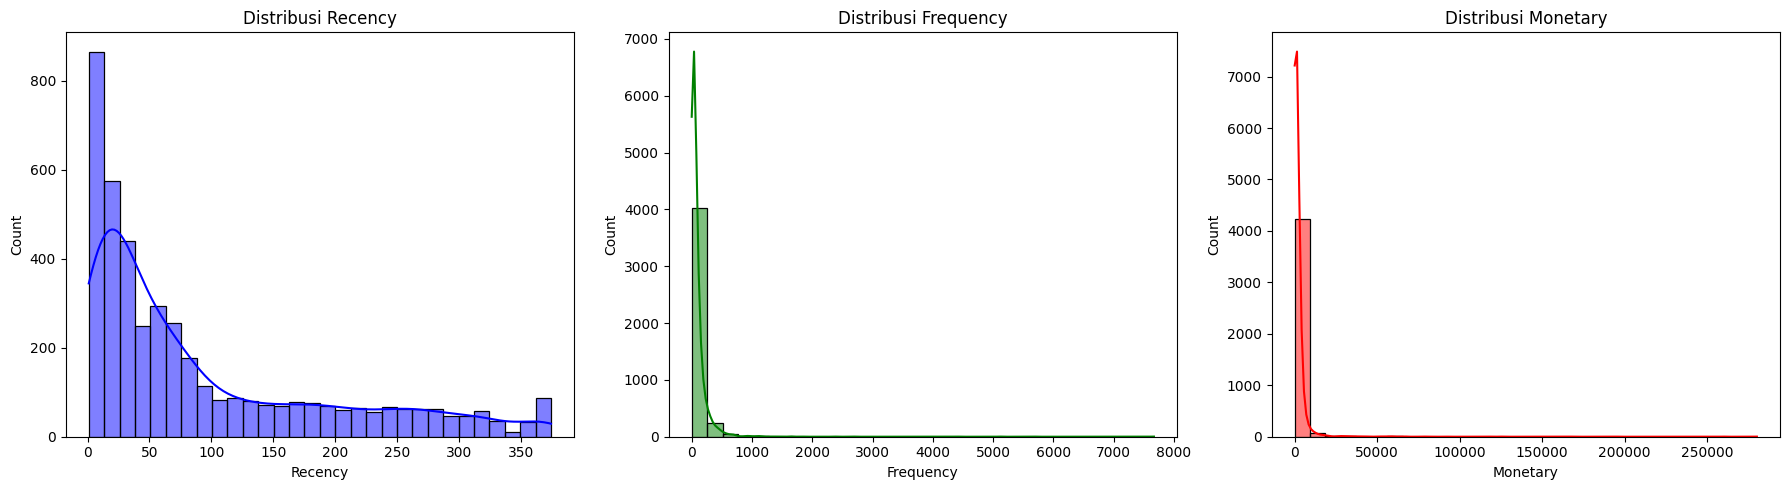

In [ ]:
# Membuat histogram untuk setiap variabel RFM
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm["Recency"], bins=30, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Distribusi Recency")

sns.histplot(rfm["Frequency"], bins=30, kde=True, ax=axes[1], color="green")
axes[1].set_title("Distribusi Frequency")

sns.histplot(rfm["Monetary"], bins=30, kde=True, ax=axes[2], color="red")
axes[2].set_title("Distribusi Monetary")

plt.tight_layout()
plt.show()

## Apakah pelanggan lebih sering melakukan transaksi (Frequency tinggi) atau kebanyakan pelanggan sudah lama tidak bertransaksi (Recency tinggi)?

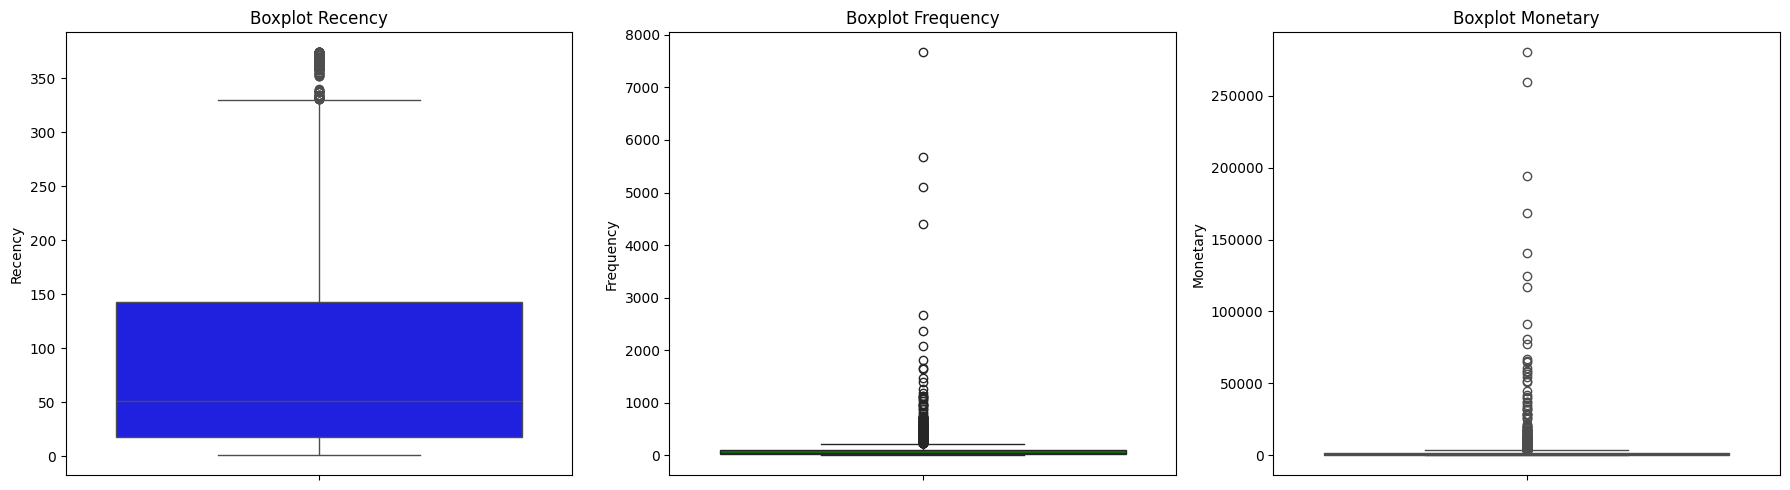

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(y=rfm["Recency"], ax=axes[0], color="blue")
axes[0].set_title("Boxplot Recency")

sns.boxplot(y=rfm["Frequency"], ax=axes[1], color="green")
axes[1].set_title("Boxplot Frequency")

sns.boxplot(y=rfm["Monetary"], ax=axes[2], color="red")
axes[2].set_title("Boxplot Monetary")

plt.tight_layout()
plt.show()

### Apakah ada pelanggan yang memiliki jumlah transaksi sangat tinggi atau nilai belanja yang ekstrem?

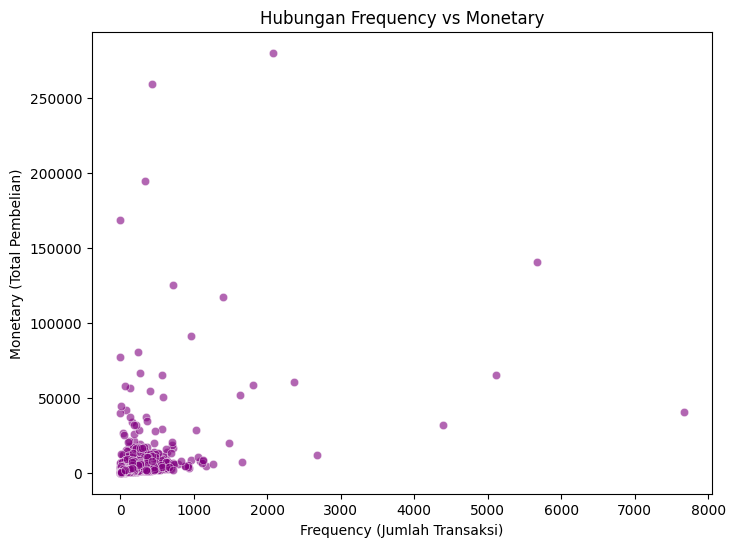

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=rfm["Frequency"], y=rfm["Monetary"], color="purple", alpha=0.6)

plt.xlabel("Frequency (Jumlah Transaksi)")
plt.ylabel("Monetary (Total Pembelian)")
plt.title("Hubungan Frequency vs Monetary")
plt.show()

## Apakah semakin sering pelanggan bertransaksi, semakin besar nilai uang yang mereka belanjakan?

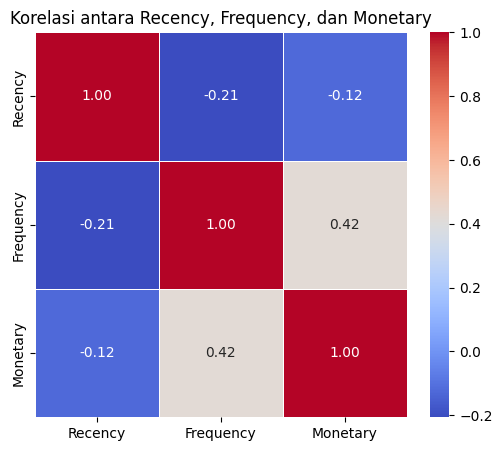

In [ ]:
plt.figure(figsize=(6,5))
sns.heatmap(rfm[['Recency', 'Frequency', 'Monetary']].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelasi antara Recency, Frequency, dan Monetary")
plt.show()

### Apakah Frequency dan Monetary memiliki korelasi tinggi? Jika iya, pelanggan yang sering belanja biasanya juga menghabiskan banyak uang.

In [ ]:
# Normalisasi data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
rfm_scaled = np.nan_to_num(rfm_scaled, nan=np.nanmedian(rfm_scaled))

In [ ]:
# Menggunakan Elbow Method untuk mencari n cluster yang optimal
result = {}

cluster_range = range(1, 21)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)

    inertia = kmeans.inertia_
    distortion = sum(np.min(cdist(rfm_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)**2) / rfm_scaled.shape[0]

    result[k] = [inertia, distortion]

previous_inertia = None
print(f"{'':<6} {'n_clusters':<9} {'':} || {'':<3} {'inertia':<12} || {'':<1} {'distortion':<12} || {'':<4} {'inertia drop'}")
print("-" * 80)
for n_clusters, value in result.items():
    inertia = value[0]
    distortion = value[1]

    inertia_drop = inertia - previous_inertia if previous_inertia is not None else None
    previous_inertia = inertia

    print(f"{'':<7} {n_clusters:<9} {'':} || {'':<3} {inertia:<12.2f} || {'':<3} {distortion:<10.2f} || {'':<3} {inertia_drop if inertia_drop is not None else 'N/A'}")

       n_clusters  ||     inertia      ||   distortion   ||      inertia drop
--------------------------------------------------------------------------------
        1          ||     13005.00     ||     3.00       ||     N/A
        2          ||     8983.07      ||     2.07       ||     -4021.9349161551454
        3          ||     5440.88      ||     1.26       ||     -3542.188640918819
        4          ||     3992.79      ||     0.92       ||     -1448.0852876070048
        5          ||     2953.53      ||     0.68       ||     -1039.265013985917
        6          ||     2363.68      ||     0.55       ||     -589.8422540023776
        7          ||     1917.58      ||     0.44       ||     -446.1075243765704
        8          ||     1668.14      ||     0.38       ||     -249.43769314687438
        9          ||     1472.38      ||     0.34       ||     -195.75577011062433
        10         ||     1309.41      ||     0.30       ||     -162.97621011635692
        11         ||

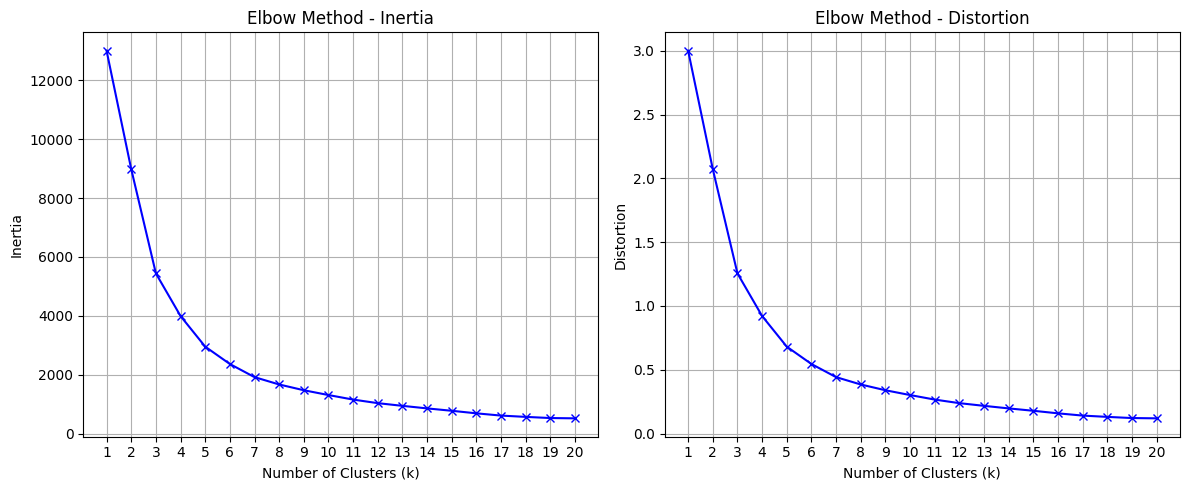

In [ ]:
# Create a side-by-side plot (1 row, 2 columns)
distortion_values = [value[1] for _, value in result.items()]
inertia_values = [value[0] for _, value in result.items()]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Inertia
axes[0].plot(cluster_range, inertia_values, 'bx-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_xticks(cluster_range)
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method - Inertia')
axes[0].grid()

# Plot Distortion
axes[1].plot(cluster_range, distortion_values, 'bx-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_xticks(cluster_range)
axes[1].set_ylabel('Distortion')
axes[1].set_title('Elbow Method - Distortion')
axes[1].grid()

# Adjust layout and show
plt.tight_layout()
plt.show()

Silhouette Score for KMeans with 2 clusters: 0.5775045310585095
Silhouette Score for KMeans with 3 clusters: 0.6028513285018015
Silhouette Score for KMeans with 4 clusters: 0.6037456020941976
Silhouette Score for KMeans with 5 clusters: 0.6146248806358536
Silhouette Score for KMeans with 6 clusters: 0.4667842887305379
Silhouette Score for KMeans with 7 clusters: 0.523840324228816
Silhouette Score for KMeans with 8 clusters: 0.5244901094070862
Silhouette Score for KMeans with 9 clusters: 0.4124729592113895


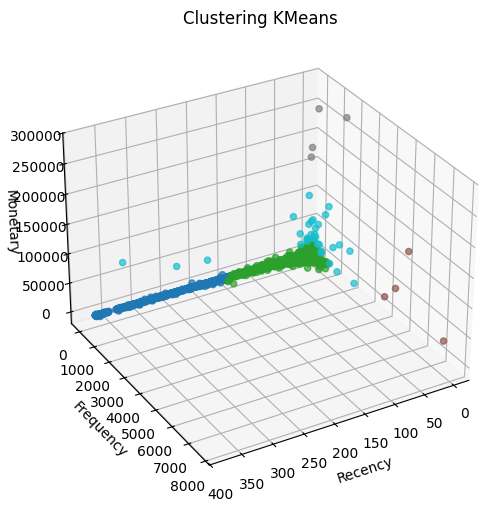

In [ ]:
# Clustering dengan KMeans untuk mendapatkan label
best_silhouette = 0
best_n_clusters = 0
for n_cluster in range(2, 10):
    X = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
    kmeans = KMeans(n_clusters=n_cluster, random_state=42)
    cluster_prediction = kmeans.fit_predict(rfm_scaled)
    silhouette_kmeans = silhouette_score(X, cluster_prediction)
    if silhouette_kmeans > best_silhouette:
        best_silhouette = silhouette_kmeans
        best_n_clusters = n_cluster
        rfm['Cluster'] = cluster_prediction
    print(f"Silhouette Score for KMeans with {n_cluster} clusters: {silhouette_kmeans}")


fig = plt.figure(figsize=(14, 6))
plt.ion()

# PLOT 3D KMeans
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
                       c=rfm['Cluster'], cmap='tab10', alpha=0.7)
ax1.set_xlabel("Recency")
ax1.set_ylabel("Frequency")
ax1.set_zlabel("Monetary")
ax1.set_title("Clustering KMeans")
ax1.view_init(elev=30, azim=60)

In [ ]:
# Training Gradient Boosting Classifier
X = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])  # Gunakan hasil scaling
y = rfm['Cluster']

# Training Gradient Boosting Classifier (GBC)
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X, y)

# Prediksi cluster baru
rfm['Cluster_Predicted'] = gbc.predict(X)

gbc_counts = rfm['Cluster_Predicted'].value_counts().sort_index()

# Hitung silhouette score untuk K-Means dan GBC
X = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
silhouette_kmeans = silhouette_score(X, rfm['Cluster'])
silhouette_gbc = silhouette_score(X, rfm['Cluster_Predicted'])

# Buat DataFrame hasil
result_df = pd.DataFrame({
    "Klaster": [f"Klaster {i+1}" for i in range(len(gbc_counts))],
    "Jumlah": gbc_counts.values,
    "Satuan": "Pelanggan",
    "Skor Silhouette": np.round(silhouette_gbc, 3),
})

result_df

,Klaster,Jumlah,Satuan,Skor Silhouette
0,Klaster 1,1073,Pelanggan,0.615
1,Klaster 2,3223,Pelanggan,0.615
2,Klaster 3,4,Pelanggan,0.615
3,Klaster 4,4,Pelanggan,0.615
4,Klaster 5,31,Pelanggan,0.615


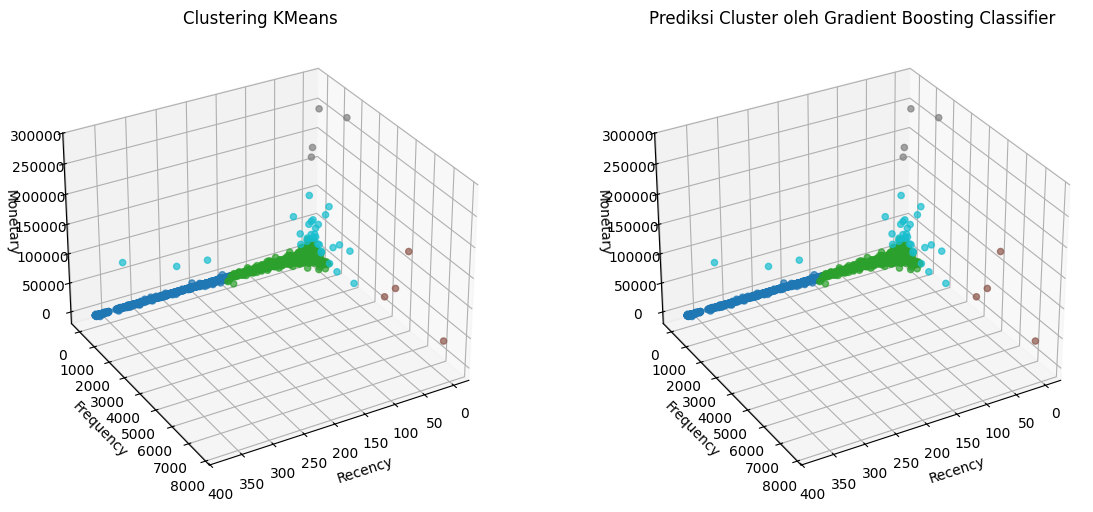

In [ ]:
# VISUALISASI DATA
fig = plt.figure(figsize=(14, 6))
plt.ion()

# PLOT 3D KMeans
ax1 = fig.add_subplot(121, projection='3d')
scatter1 = ax1.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
                       c=rfm['Cluster'], cmap='tab10', alpha=0.7)
ax1.set_xlabel("Recency")
ax1.set_ylabel("Frequency")
ax1.set_zlabel("Monetary")
ax1.set_title("Clustering KMeans")
ax1.view_init(elev=30, azim=60)

# PLOT 3D Gradient Boosting Classifier
ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
                       c=rfm['Cluster_Predicted'], cmap='tab10', alpha=0.7)
ax2.set_xlabel("Recency")
ax2.set_ylabel("Frequency")
ax2.set_zlabel("Monetary")
ax2.set_title("Prediksi Cluster oleh Gradient Boosting Classifier")
ax2.view_init(elev=30, azim=60)

# Tampilkan plot interaktif
plt.show()

In [ ]:
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("KMeans Clustering", "Gradient Boosting Predictions")
)

# Scatter plot KMeans
fig.add_trace(
    go.Scatter3d(
        x=rfm['Recency'],
        y=rfm['Frequency'],
        z=rfm['Monetary'],
        mode='markers',
        marker=dict(color=rfm['Cluster'], colorscale='Viridis', opacity=0.7),
        name="KMeans Clusters"
    ),
    row=1, col=1
)

# Scatter plot Gradient Boosting
fig.add_trace(
    go.Scatter3d(
        x=rfm['Recency'],
        y=rfm['Frequency'],
        z=rfm['Monetary'],
        mode='markers',
        marker=dict(color=rfm['Cluster_Predicted'], colorscale='Viridis', opacity=0.7),
        name="GBC Predictions"
    ),
    row=1, col=2
)

# Layout
fig.update_layout(
    title_text="Clustering KMeans vs Gradient Boosting Classifier",
    height=600, width=1000,
    scene=dict(xaxis_title="Recency", yaxis_title="Frequency", zaxis_title="Monetary")
)

fig.show()

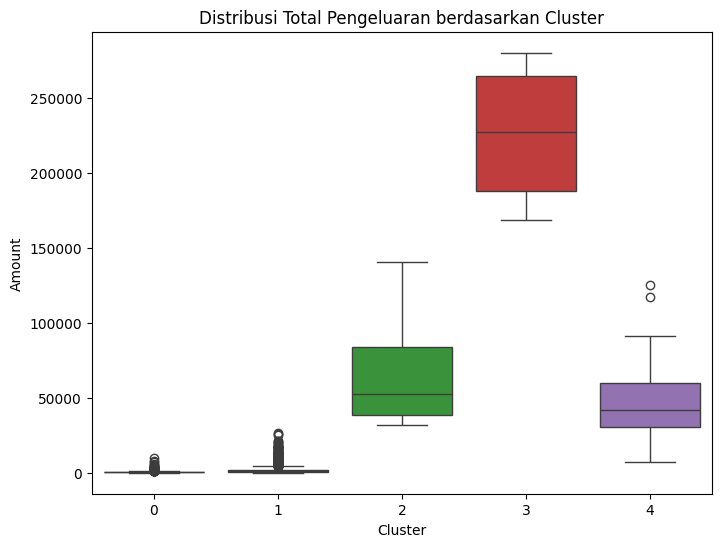

In [ ]:
# Visualisasi Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=rfm, x='Cluster_Predicted', y='Monetary', hue="Cluster_Predicted", palette="tab10", legend=False)

plt.title("Distribusi Total Pengeluaran berdasarkan Cluster")
plt.xlabel("Cluster")
plt.ylabel("Amount")
plt.xticks()
plt.show()

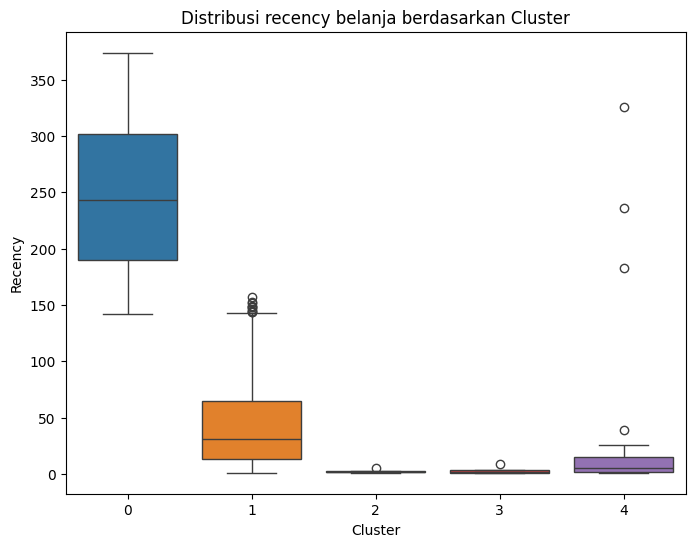

In [ ]:
# Visualisasi Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=rfm, x='Cluster_Predicted', y='Recency', hue="Cluster_Predicted", palette="tab10", legend=False)

plt.title("Distribusi recency belanja berdasarkan Cluster")
plt.xlabel("Cluster")
plt.ylabel("Recency")
plt.show()

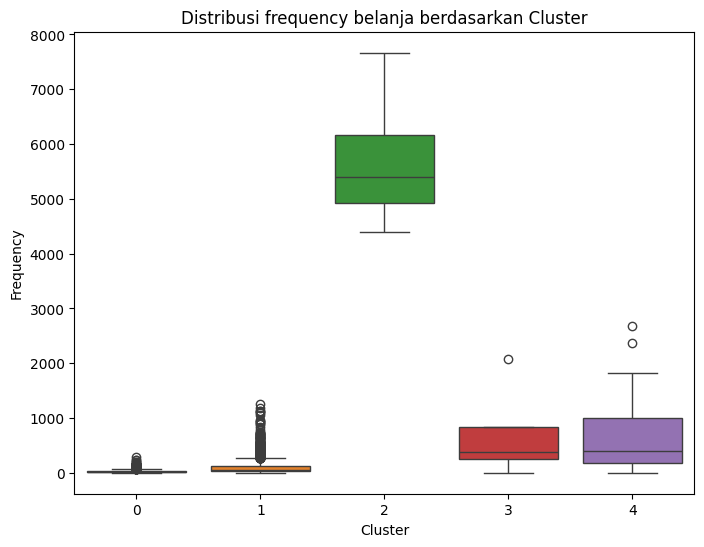

In [ ]:
# Visualisasi Boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=rfm, x='Cluster_Predicted', y='Frequency', hue="Cluster_Predicted", palette="tab10", legend=False)

plt.title("Distribusi frequency belanja berdasarkan Cluster")
plt.xlabel("Cluster")
plt.ylabel("Frequency")
plt.show()

In [ ]:
cluster_stats = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median', 'min', 'max'],
    'Frequency': ['mean', 'median', 'min', 'max'],
    'Monetary': ['mean', 'median', 'min', 'max'],
    'ID_Customer': 'count'  # Count of customers in each cluster
}).reset_index()

# Rename columns for clarity
cluster_stats.columns = ['Cluster',
                         'Recency_Mean', 'Recency_Median', 'Recency_Min', 'Recency_Max',
                         'Frequency_Mean', 'Frequency_Median', 'Frequency_Min', 'Frequency_Max',
                         'Monetary_Mean', 'Monetary_Median', 'Monetary_Min', 'Monetary_Max',
                         'Customer_Count']

usd_columns = ['Monetary_Mean', 'Monetary_Median', 'Monetary_Min', 'Monetary_Max']
cluster_stats[usd_columns] = cluster_stats[usd_columns].apply(lambda col: col.map(lambda x: f"${x:,.2f}"))

# Print the result
cluster_stats

,Cluster,Recency_Mean,Recency_Median,Recency_Min,Recency_Max,Frequency_Mean,Frequency_Median,Frequency_Min,Frequency_Max,Monetary_Mean,Monetary_Median,Monetary_Min,Monetary_Max,Customer_Count
0,0,248.575023,243.0,142,374,27.602050,18.0,1,297,$488.56,$310.05,$3.75,"$9,864.26",1073
1,1,42.256593,31.0,1,157,97.886751,55.0,1,1262,"$1,740.04",$908.86,$0.00,"$26,626.80",3223
2,2,2.500000,2.0,1,5,5711.500000,5390.5,4398,7667,"$69,413.10","$52,830.39","$31,654.78","$140,336.83",4
3,3,3.250000,1.5,1,9,712.500000,383.5,3,2080,"$225,681.65","$227,024.04","$168,472.50","$280,206.02",4
4,4,31.967742,5.0,1,326,695.193548,403.0,1,2675,"$49,020.48","$42,055.96","$7,411.71","$124,914.53",31


In [ ]:
clean_df[clean_df['ID_Customer'].isin(rfm[rfm["Cluster"] == 0]["ID_Customer"])]["Negara"].value_counts(normalize=True)

,proportion
Negara,
United Kingdom,0.904886
Germany,0.021711
France,0.014316
Belgium,0.005976
Switzerland,0.005504
EIRE,0.005436
Portugal,0.004457
Italy,0.003950
Greece,0.003680


In [ ]:
clean_df[clean_df['ID_Customer'].isin(rfm[rfm["Cluster"] == 1]["ID_Customer"])]["Negara"].value_counts(normalize=True)

,proportion
Negara,
United Kingdom,0.903039
Germany,0.026543
France,0.025031
Spain,0.007579
Belgium,0.005877
Switzerland,0.005322
Portugal,0.004165
Norway,0.003335
Channel Islands,0.002079


In [ ]:
clean_df[clean_df['ID_Customer'].isin(rfm[rfm["Cluster"] == 2]["ID_Customer"])]["Negara"].value_counts(normalize=True)

,proportion
Negara,
United Kingdom,0.751817
EIRE,0.248183


In [ ]:
clean_df[clean_df['ID_Customer'].isin(rfm[rfm["Cluster"] == 3]["ID_Customer"])]["Negara"].value_counts(normalize=True)

,proportion
Negara,
Netherlands,0.729825
United Kingdom,0.270175


In [ ]:
clean_df[clean_df['ID_Customer'].isin(rfm[rfm["Cluster"] == 4]["ID_Customer"])]["Negara"].value_counts(normalize=True)

,proportion
Negara,
United Kingdom,0.892905
EIRE,0.064730
Australia,0.033224
Sweden,0.009141


In [ ]:
# Definisikan karakteristik pelanggan berdasarkan klaster (sesuai kebutuhan)
cluster_characteristics = {
    0: "Casual Buyers",
    1: "Regular Customers",
    2: "High-Volume Buyers",
    3: "Wholesale Buyers",
    4: "Premium Customers
}

# Buat DataFrame hasil
result_df = pd.DataFrame({
    "Nama Klaster": [cluster_characteristics[i] for i in range(len(gbc_counts))],
    "Rata-rata Recency": rfm.groupby("Cluster")["Recency"].mean().values,
    "Rata-rata Frequency": rfm.groupby("Cluster")["Frequency"].mean().values,
    "Rata-rata Monetary": rfm.groupby("Cluster")["Monetary"].mean().values,
    "Distribusi Geografis": ["90,5% UK", "90,5% UK", "75% UK, 25% EIRE", "72,5% Netherlands, 27,5% UK", "89,3% UK"],
    "Jumlah Pelanggan": gbc_counts.values,
    "Skor Silhouette GBC": np.round(silhouette_gbc, 3),
})

result_df

,Nama Klaster,Rata-rata Recency,Rata-rata Frequency,Rata-rata Monetary,Distribusi Geografis,Jumlah Pelanggan,Skor Silhouette GBC
0,Casual Buyers,248.575023,27.602050,488.563226,"90,5% UK",1073,0.615
1,Regular Customers,42.256593,97.886751,1740.041837,"90,5% UK",3223,0.615
2,High-Volume Buyers,2.500000,5711.500000,69413.097500,"75% UK, 25% EIRE",4,0.615
3,Wholesale Buyers,3.250000,712.500000,225681.652500,"72,5% Netherlands, 27,5% UK",4,0.615
4,Premium Customers,31.967742,695.193548,49020.476774,"89,3% UK",31,0.615


# TEST

In [ ]:
# Apa itu early stopping, tunjukkan di program, gunakan early stopping = 20, validation split = 0.2
# Early stopping adalah metode untuk memberhentikan training agar tidak terjadi overfit dimana pada metrik loss pada training menurun sementara metrik loss pada
# validation tidak membaik (stagnan atau malah naik)

# RESET
rfm = rfm.drop(columns=["Negara", "ID_Customer"])
rfm = rfm.drop(columns=["Cluster_Predicted"])
rfm

,Recency,Frequency,Monetary,Cluster
0,326,1,77183.60,4
1,3,182,4310.00,1
2,76,31,1797.24,1
3,19,73,1757.55,1
4,311,17,334.40,0
...,...,...,...,...
4330,278,10,180.60,0
4331,181,7,80.82,0
4332,8,12,178.05,1
4333,4,719,2039.58,1


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
# Scaling
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
rfm_scaled = np.nan_to_num(rfm_scaled, nan=np.nanmedian(rfm_scaled))

In [ ]:
X = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary', "Cluster"])
X = X.drop(columns=["Cluster"])
y = rfm["Cluster"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# ADD EARLY STOPPING TO GBC
gbc = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42,
    validation_fraction=0.2,  # Validation Split Dari Test Test
    n_iter_no_change=20,   # Early Stopping
)
gbc.fit(X_train, y_train)

result = gbc.predict(X_test)
ABC = accuracy_score(y_test, result)
F1 = f1_score(y_test, result, average="weighted")
cm = confusion_matrix(y_test, result)
print(f"Akurasi Gradient Boosting Classifier: {ABC}")
print(f"F1 Score Gradient Boosting Classifier: {F1}")
cm

Akurasi Gradient Boosting Classifier: 0.9907727797001153
F1 Score Gradient Boosting Classifier: 0.9905003015777277


array([[215,   2,   0,   0,   0],
       [  4, 639,   0,   0,   0],
       [  0,   0,   1,   0,   0],
       [  0,   0,   0,   1,   0],
       [  0,   2,   0,   0,   3]])

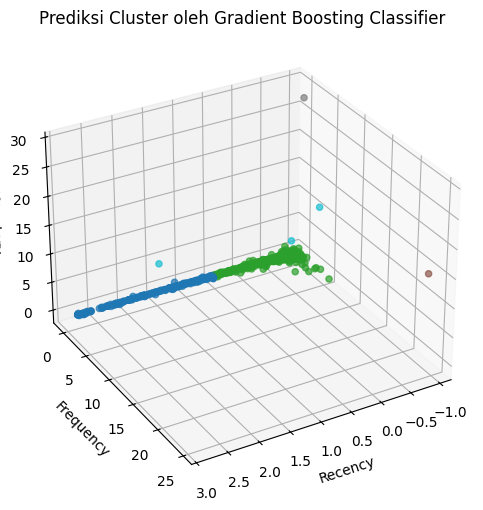

In [ ]:
# Plot Visualisasi dan Hasilnya
fig = plt.figure(figsize=(14, 6))
plt.ion()

ax2 = fig.add_subplot(122, projection='3d')
scatter2 = ax2.scatter(X_test['Recency'], X_test['Frequency'], X_test['Monetary'],
                       c=result, cmap='tab10', alpha=0.7)
ax2.set_xlabel("Recency")
ax2.set_ylabel("Frequency")
ax2.set_zlabel("Monetary")
ax2.set_title("Prediksi Cluster oleh Gradient Boosting Classifier")
ax2.view_init(elev=30, azim=60)

plt.show()